First of all, pulling some simple raw data from the Account table in Looker. Trying start with non processed data hence looking at fields obtained from Angaza that are used to build the Account view.

In [7]:
# Importing pandas

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import looker
import json
import yaml

%matplotlib inline

In [8]:
host = 'localhost'
f = open('config.yml')
params = yaml.load(f)
f.close()

base_url = params['hosts'][host]['host']
client_secret = params['hosts'][host]['secret']
client_id = params['hosts'][host]['token']

In [9]:
# instantiate Auth API
unauthenticated_client = looker.ApiClient(base_url)
unauthenticated_authApi = looker.ApiAuthApi(unauthenticated_client)

# authenticate client
token = unauthenticated_authApi.login(client_id=client_id, client_secret=client_secret)
client = looker.ApiClient(base_url, 'Authorization', 'token ' + token.access_token)

# instantiate User API client
userApi = looker.UserApi(client)
me = userApi.me()

In [68]:
query_body =  json.loads(open("20181212 - Accounts in Kenya.json", "r").read())
result_type = 'json'
Q = looker.QueryApi(client)
result = Q.run_inline_query(result_type,query_body).replace("'", '"').replace('None','"None"')

In [69]:
#account.product_name
#print(result[:500])

In [70]:
# Creating data frame from query into Looker
account = pd.read_json(result, orient = 'records')

# Resetting each column name, in particular 'do_you_use_kerosene/paraffin_now'
account.columns = ['status', 'angaza_id', 'country','cumulative_days_disabled', 'customer_age', 'customer_gender', 
       'customer_region', 'customer_secondary_phone_number', 'disablement_date', 'latest_payment_date', 
       'days_to_cutoff', 'electrification', 'expected_paid', 'group_name', 'minimum_payment_amount', 'number_of_payments', 
       'organization', 'phone_number', 'customer_name', 'price_per_day', 'product_name',
       'registering_agent_name', 'registering_agent_id', 'registration_date', 'latitudelongitude',
       'responsible_agent_name', 'responsible_agent_id', 'responsible_agent_since_date', 'test_account', 'total_paid',
       'unlock_price', 'upfront_price']

# account.head() # uncomment to print the first 5 rows of the table

,status,angaza_id,country,cumulative_days_disabled,customer_age,customer_gender,customer_region,customer_secondary_phone_number,disablement_date,latest_payment_date,...,registering_agent_id,registration_date,latitudelongitude,responsible_agent_name,responsible_agent_id,responsible_agent_since_date,test_account,total_paid,unlock_price,upfront_price
0,ENABLED,AC055529,Kenya,535,45,FEMALE,Kakamega,na,2018-12-12,2018-12-08,...,US002158,2017-02-28,"0.286083,34.7532878",Mercy Velma (mercyvelma),US022463,2018-06-20,false,69.046226,104.349522,15.603667
1,UNLOCKED,AC055460,Kenya,6,55,MALE,Kitale,0795407721,None,2017-08-18,...,US002159,2017-02-28,"0.0242281176915,34.7112683575",Antony Odinga (antonyodinga),US002159,2017-02-28,false,104.349522,104.349522,15.603667
2,UNLOCKED,AC055539,Kenya,96,46,MALE,Kakamega,0712538067,None,2017-12-07,...,US001663,2017-02-28,"0.5435851,34.171099",Dorice Iliwa (doriceiliwa),US001663,2017-02-28,false,104.349522,104.349522,15.603667
3,UNLOCKED,AC055473,Kenya,143,45,MALE,Busia,0726326106,None,2018-01-24,...,US003064,2017-02-28,"0.44809,34.252915",Jamal Omondi (jamalomondi),US003064,2017-02-28,false,104.349522,104.349522,15.603667
4,UNLOCKED,AC055498,Kenya,18,52,MALE,Kakamega,0703432822,None,2017-09-06,...,US000528,2017-02-28,"0.3321717,34.5746669",Clive Nyero (clivenyero),US022081,2018-07-24,false,104.349522,104.349522,15.603667


In [71]:
# dropping rows with missing account number
account.dropna(subset=['angaza_id'], inplace = True) 

# dropping columns with over 500 empty values
account.dropna(axis = 1, thresh = 100, inplace = True)

# resetting the row index
account = account.reset_index(drop=True) 

# turning dates into date format
account.registration_date = pd.to_datetime(account.registration_date)
account.latest_payment_date = pd.to_datetime(account.latest_payment_date)
account.disablement_date = pd.to_datetime(account.disablement_date, errors = 'coerce')
account.responsible_agent_since_date = pd.to_datetime(account.responsible_agent_since_date)


# Creating Latitude and Longitude columns from registration_location_latitudelongitude and assigning correct dtype
account['latitude']= account['latitudelongitude'].str.split(",", n = 1, expand = True)[0]
account.latitude = pd.to_numeric(account.latitude, errors = 'coerce')

account['longitude']= account['latitudelongitude'].str.split(",", n = 1, expand = True)[1]
account.longitude = pd.to_numeric(account.longitude, errors = 'coerce')

# Dropping old registration_location_latitudelongitude column
account.drop(['latitudelongitude'], axis = 1, inplace = True)

In [72]:
#account.dtypes # uncomment to print each column with its dtype

In [73]:
# Creating a sub DataFrame from which to calculate the Correlation matrix without modifying the imported DataFrame
filtered_account = account.loc[:,['country', 'latitude', 'longitude', 'status', 'registration_date', 'registering_agent_id', 'unlock_price', 'total_paid', 'latest_payment_date', 'number_of_payments', 'customer_gender', 'customer_age', 'customer_region', 'product_name', 'cumulative_days_disabled']]

# Columns that could be added back: account_number, registering_user, upfront_price, hour_price, minimum_payment_amount, 
# Columns that need  dimension created for in looker: do_you_use_kerosene, is_the_client_the_main_user, where_is_the_product_used

In [74]:
# Automatically turning all string into numeric category value

filtered_account['country'] = filtered_account.country.astype("category").cat.codes
filtered_account['registering_agent_id'] = filtered_account.registering_agent_id.astype("category").cat.codes
filtered_account['customer_gender'] = filtered_account.customer_gender.astype("category").cat.codes
filtered_account['customer_region'] = filtered_account.customer_region.astype("category").cat.codes
filtered_account['product_name'] = filtered_account.product_name.astype("category").cat.codes

In [75]:
# transforming the account_status into a numbered column with Disabled = -1, Enabled = 0, Unlocked = 1
ordered_status = ['ENABLED', 'UNLOCKED']
filtered_account.status = filtered_account.status.astype("category", ordered=True, categories=ordered_status).cat.codes

In [76]:
# filtered_account.dtypes # uncomment to print filtered_account column list and dtypes

In [77]:
# filtered_account.head() # uncomment to print first five rows of new DataFrame

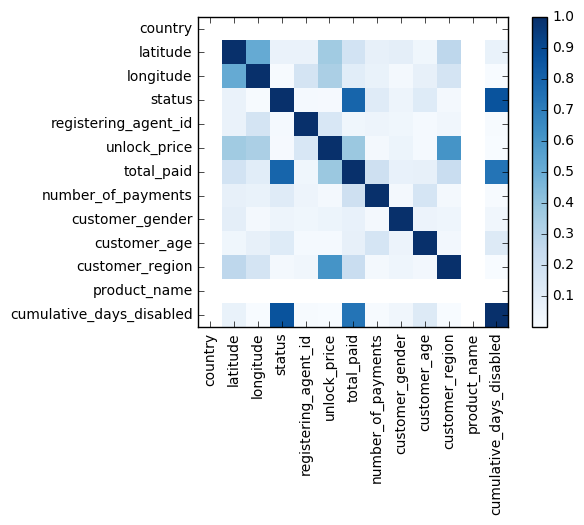

In [78]:
# Creating the Correlation matrix. Using absolute value as values in filtered_account are not necessarily ordered
c = filtered_account.corr().abs()

# Generating the visualization
plt.imshow(c, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(c.columns))]
plt.xticks(tick_marks, c.columns, rotation='vertical')
plt.yticks(tick_marks, c.columns)

# Display the graphs:
plt.show()

In [79]:
# creating a more narrowed down DataFrame for the dimensions that seem the most interesting
detailed_account = filtered_account.loc[:,['latitude', 'longitude', 'status', 'registration_date', 'registering_agent_id', 'latest_payment_date', 'number_of_payments', 'customer_gender', 'customer_age', 'customer_region', 'product_name']]

#detailed_account.head() # uncomment to print first five rows of new DataFrame

([<matplotlib.axis.YTick at 0x11f186cf8>,
 <a list of 9 Text yticklabel objects>)

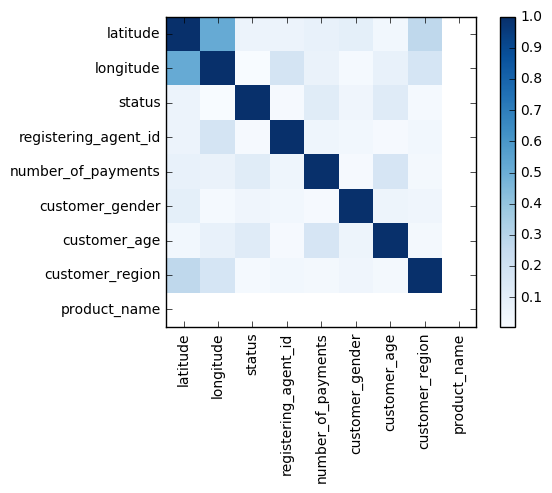

In [80]:
# Creating a new Correlation matrix. Using absolute value as values in filtered_account are not necessarily ordered
c_2 = detailed_account.corr().abs()

## Removing the auto-correlation to adapt coloring scale - uncomment when needed
# c_2.loc['latitude', 'latitude'] = 0
# c_2.loc['longitude', 'longitude'] = 0
# c_2.loc['account_status', 'account_status'] = 0
# c_2.loc['registering_user_angaza_id', 'registering_user_angaza_id'] = 0
# c_2.loc['number_of_payments', 'number_of_payments'] = 0
# c_2.loc['customer_gender', 'customer_gender'] = 0
# c_2.loc['customer_age', 'customer_age'] = 0
# c_2.loc['customer_region', 'customer_region'] = 0
# c_2.loc['product_name', 'product_name'] = 0
# c_2.loc['do_you_use_kerosene', 'do_you_use_kerosene'] = 0
# c_2.loc['is_the_client_the_main_user', 'is_the_client_the_main_user'] = 0
# c_2.loc['where_is_the_product_used', 'where_is_the_product_used'] = 0 
#########################


## Removing the some correlations to adapt coloring scale and see more tenuous relationships - uncomment when needed
# c_2.loc['latitude', 'longitude'] = 0
# c_2.loc['longitude', 'latitude'] = 0
# c_2.loc['is_the_client_the_main_user', 'where_is_the_product_used'] = 0
# c_2.loc['where_is_the_product_used', 'is_the_client_the_main_user'] = 0
# c_2.loc['product_name', 'number_of_payments'] = 0
# c_2.loc['number_of_payments', 'product_name'] = 0
#########################

# Generating the visualization
plt.imshow(c_2, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(c_2.columns))]
plt.xticks(tick_marks, c_2.columns, rotation='vertical')
plt.yticks(tick_marks, c_2.columns)

# Display the graphs:
#plt.show()

In [81]:
# Printing Correlation matrix for detailed review
# c_2

### Example of what boxplot could bring in order to analyze categorical distribution of customers based on a certain characteristic.

We use gender here as a way of illustration. I do not think that it would be a relevant metric to be used for business decision.

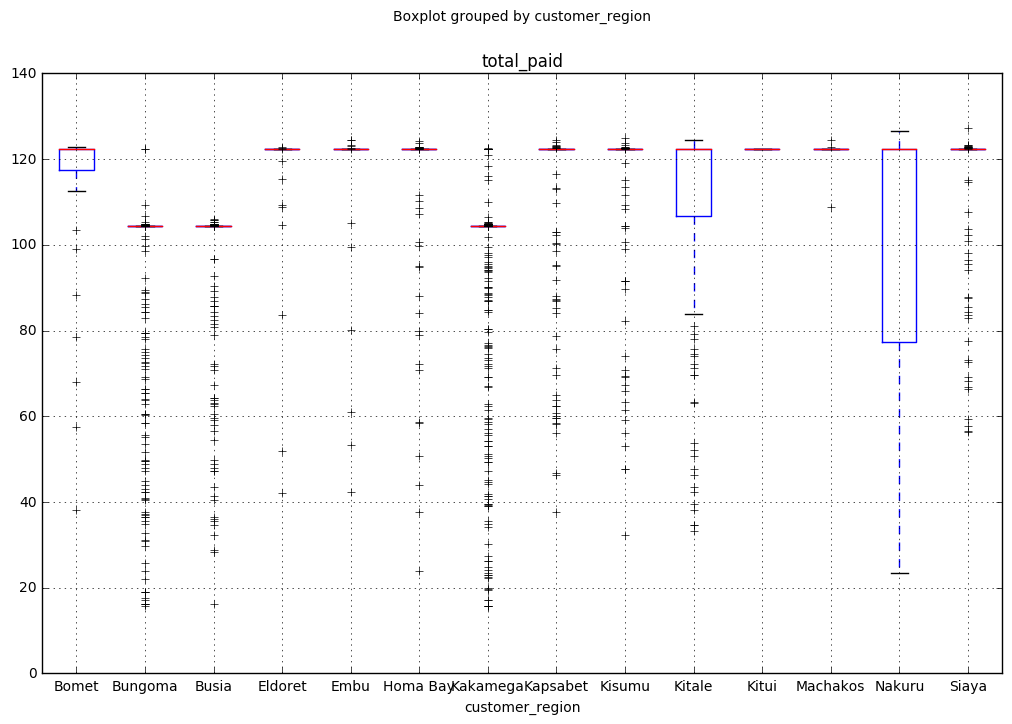

In [82]:
account.boxplot('total_paid', by='customer_region', figsize=(12, 8))

In [90]:
# Print the table describing the total_paid for each region of origin of existing customers
print(account.loc[:,['total_paid','customer_region']].groupby('customer_region').describe().reset_index().pivot(index='customer_region', values='total_paid', columns='level_1'))

level_1                 25%         50%         75%  count         max  \
customer_region                                                          
Bomet            117.446850  122.391262  122.391262   31.0  122.878877   
Bungoma          104.349522  104.349522  104.349522  329.0  122.391262   
Busia            104.349522  104.349522  104.349522  223.0  105.909889   
Eldoret          122.391262  122.391262  122.391262   44.0  122.878877   
Embu             122.391262  122.391262  122.391262   47.0  124.341720   
Homa Bay         122.391262  122.391262  122.391262  114.0  124.107665   
Kakamega         104.349522  104.349522  104.349522  514.0  122.488785   
Kapsabet         122.391262  122.391262  122.391262  155.0  124.341720   
Kisumu           122.391262  122.391262  122.391262  162.0  124.829335   
Kitale           106.641311  122.391262  122.391262  145.0  124.341720   
Kitui            122.391262  122.391262  122.391262    3.0  122.391262   
Machakos         122.391262  122.39126

The means are close but the median is widely different.

### Experiment to apply ANOVA to the data set segmenting it by the gender category.

In [84]:
data = account.loc[:,['total_paid','customer_region']]

k = len(pd.unique(data.customer_region))  # number of conditions
N = len(data.values)  # conditions times participants
n = data.groupby('customer_region').size()[0] #Participants in each condition

DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

from scipy import stats

SSbetween = (sum(data.groupby('customer_region').sum()['total_paid']**2)/n) - (data['total_paid'].sum()**2)/N

sum_y_squared = sum([value**2 for value in data['total_paid'].values])
SSwithin = sum_y_squared - sum(data.groupby('customer_region').sum()['total_paid']**2)/n

SStotal = sum_y_squared - (data['total_paid'].sum()**2)/N

MSbetween = SSbetween/DFbetween
MSwithin = SSwithin/DFwithin
F = MSbetween/MSwithin

print('SSbetween: ', "{:.2E}".format(SSbetween), ' - ','SSwithin: ', "{:.2E}".format(SSwithin), ' - ','SStotal: ', "{:.2E}".format(SStotal))

p = stats.f.sf(F, DFbetween, DFwithin)
#eta2 = SSbetween/SStotal
#om2 = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

SSbetween:  1.50E+08  -  SSwithin:  -1.49E+08  -  SStotal:  1.16E+06


In [85]:
print('MSbetween: ', "{:.2E}".format(MSbetween), ' - ','MSwithin: ', "{:.2E}".format(MSwithin), ' - ','F2: ', "{:.2f}".format(F))

MSbetween:  1.15E+07  -  MSwithin:  -7.44E+04  -  F2:  -155.04


We use ANOVA to test the null hypothesis that assumes that the gender does affect the amount paid by the customer. If p < 0.05 then there is only a 5% chance for this to be true and therefore we can establish a correlation between gender and amount paid. 

In [86]:
print('p = ', "{:.2%}".format(p), ' >> 0.05') 

p =  100.00%  >> 0.05


p being 100%, we can reject the hypothesis that the amount paid is related to the customer gender

In [87]:
SSbetween2 = sum((data.groupby('customer_region').sum() / data.groupby('customer_region').mean()).values*(data.groupby('customer_region').mean().values - data['total_paid'].mean())**2)[0]
SStotal2 = sum((data['total_paid'].values - data['total_paid'].mean())**2)
SSwithin2 = SStotal2 - SSbetween2

# we print each of the variable
print('SSbetween2: ', "{:.2E}".format(SSbetween2), ' - ','SSwithin2: ', "{:.2E}".format(SSwithin2), ' - ','SStotal2: ', "{:.2E}".format(SStotal2))

SSbetween2:  1.86E+05  -  SSwithin2:  9.69E+05  -  SStotal2:  1.16E+06


In [88]:
# we calculate the minimum squares and F

MSbetween2 = SSbetween2/DFbetween
MSwithin2 = SSwithin2/DFwithin
F2 = MSbetween2/MSwithin2

print('MSbetween2: ', "{:.2E}".format(MSbetween2), ' - ','MSwithin2: ', "{:.2E}".format(MSwithin2), ' - ','F2: ', "{:.2f}".format(F2))

MSbetween2:  1.43E+04  -  MSwithin2:  4.84E+02  -  F2:  29.60


In [89]:
# And we finally get p:

p2 = stats.f.sf(F2, DFbetween, DFwithin)
print('p_2 = ', "{:.2E}".format(p2))

p_2 =  1.88E-67


### Testing two-sample Welsh t-test

In [ ]:
from scipy import stats

In [ ]:
sp1 = data[data.customer_gender == 'FEMALE'].iloc[:,0]
sp2 = data[data.customer_gender == 'MALE'].iloc[:,0]

In [ ]:
stats.ttest_ind(sp1, sp2, equal_var = False)

p > 0.05 hence we reject again that the amount paid by male and female customers is different